저는 평소에 주가 예측과 퀀트 시스템에 큰 관심이 있는 사람입니다.  
이번 경진대회에 큰 기대를 하고 있었는데 막상 경진대회가 시작되고 보니 생각보다 허술한 설계에 조금 당황했습니다.  
아래부터 제가 이번 경진대회를 진행하며 느낀 바를 허심탄회하게 풀어보려고 합니다.

### <strong>첫 번째로 지적하고 싶은 가장 큰 문제는 이 "데이터 분석" 경진대회에는 private leaderboard가 없다는 것입니다.<strong>

일반적인 데이터 분석 경진대회는 leaderboard를 두 가지 운영합니다.  
하나는 지금 우리가 "랭킹보드"라고 부르는 "public leaderboard" 입니다.  
public leaderboard는 참여자가 result를 제시하면 그 자리에서 채점해 순위를 공개합니다.  

그리고 다른 하나가 "private leaderboard" 입니다.  
private leaderboard는 경진대회가 끝날 때까지 참여자에게 점수를 공개해주지 않습니다.  
모든 경진대회가 끝나고, 경진대회 운영팀은 참여자가 제출한 result에 숨어 있는 private data를 채점해 private leaderboard를 공개합니다.  
그리고 최종 순위는 public과 private를 섞어서 산출하거나 private only로 매겨집니다.

<u>이렇게 운영하는 이유는 public leaderboard는 많은 경우 대회과정에서 해킹되기 때문입니다.</u>

참여자들이 public leaderboard에 표시되는 자신의 점수를 보고 모델의 hyper-parameter를 수정하므로 public leaderboard와 참여자의 F/B이 잦아질수록 해당 참여자의 모델은 public dataset에 over-fitting됩니다.  
결국 public leaderboard에서 성적은 점점 높아지나 이 over-fitting 문제를 validation으로 적절히 해결하지 못하면 그 참여자는 private leaderboard에서 참패를 면할 수 없는 구조이죠.

* 이에 대한 더 자세한 사례는 다음 링크를 참조하세요.
* https://gregpark.io/blog/Kaggle-Psychopathy-Postmortem/

### <strong>두 번째로, 이 경진대회는 제출 횟수가 무제한 입니다.  <strong>

보통 일반적인 데이터 분석 경진대회는 제출 횟수를 제한적으로 통제합니다.  
이 경진대회가 대회가 아닌 일반 과제였다면 아무 상관이 없었을 것입니다.  
하지만 어쨌거나 대회인 이상 문제가 될 수 밖에 없었고, 특히 후술할 세 번째 문제점과 결합해서 더 큰 맹점을 만들었습니다.

### <strong>세 번째로, 이 경진대회는 코드 안에서 제출 결과(MAE)를 변수로 F/B 받을 수 있는 구조입니다.<strong>

다음과 같은 코드를 통하여 "elice_grade result.csv" 명령을 실행 했을 때 떨어지는 print문을 코드 안으로 낚아챌 수가 있습니다.  

In [2]:
import pandas as pd
import subprocess

def what_is_my_score(result_df):
    # result_df를 results_csv로 저장
    result_df.to_csv("result.csv")
    
    getscore =  subprocess.Popen("elice_grade result.csv", shell=True, stdout=subprocess.PIPE).stdout
    score =  getscore.read()
    score = float(score.decode('utf-8').split('\n')[3].split(' ')[-1])

    return score

result_df = pd.read_csv("result.csv", index_col = 0)
score = what_is_my_score(result_df)
print("내 점수는요~ ", score)

Compressed 10240 bytes into 2760 bytes ==> 26.95%


내 점수는요~  0.001999


 덤으로 이 함수를 응용하면 이 경진대회의 result.csv 안에 private dateset이 존재하지 않음을 확실히 검증할 수도 있습니다.

In [3]:
# result_df의 각 요소마다 1씩 더해서 서버에 제출한 후 Dcoll 받는 MAE(Score)가 변동하는지 확인한다.
# 만약 result_df의 모든 ind/col에서 MAE를 변동시키는 것이 확인된다면 private dataset이 존재하지 않음이 확실하다.
try:
    stop_cnt = 0
    test_add_point = 1
    private_site_list = []
    min_score = what_is_my_score(result_df)
    for col in result_df.columns:
        for ind in result_df.index:
            # 주피터 노트북 예시 코드용 stop logic
            if stop_cnt >= 10:
                raise NotimplementedError
            stop_cnt += 1
            
            result_df.loc[ind, col] += test_add_point
            score = what_is_my_score(result_df)

            if score < min_score + 0.5*test_add_point/150:
                print('private site !!', ind, col)
                private_site_list.append([ind, col])

            result_df.loc[ind, col] -= test_add_point

    if len(private_site_list) == 0:
        print("result에 private data 없음")
    else:
        print("private point : ", private_site_list)


except:
    print("(대충 이렇게 검사할 수 있다는 내용)")

Compressed 10240 bytes into 2760 bytes ==> 26.95%                              
Compressed 10240 bytes into 2760 bytes ==> 26.95%                              
Compressed 10240 bytes into 2765 bytes ==> 27.00%                              
Compressed 10240 bytes into 2765 bytes ==> 27.00%                              
Compressed 10240 bytes into 2766 bytes ==> 27.01%                              
Compressed 10240 bytes into 2765 bytes ==> 27.00%                              
Compressed 10240 bytes into 2764 bytes ==> 26.99%                              
Compressed 10240 bytes into 2764 bytes ==> 26.99%                              
Compressed 10240 bytes into 2763 bytes ==> 26.98%                              
Compressed 10240 bytes into 2761 bytes ==> 26.96%                              
Compressed 10240 bytes into 2763 bytes ==> 26.98%                              


(대충 이렇게 검사할 수 있다는 내용)


<u>제출 횟수도 무제한인데, Score도 변수로 받을 수 있고, private leaderboard는 존재하지도 않으며, 목적함수는 150개의 독립변수들로 이루어져 있는데 평가 지표가 Mean Error이기 때문에 각 독립변수에서 local optimum이 존재하지 않고 global optimum이 유일하게 존재함이 보장됩니다.</u>

이 상황에 랭킹보드를 올리기 위해서 왜 머신러닝을 써야하겠습니까?


### <strong>저는 대회 참가자로서 상기 사항들에 대한 우려를 운영진에게 전달했으나 회신을 받지 못했습니다.<strong>

그래서 그냥 이게 운영진의 의도이려니 하고 이를 이용하는 최적화 코드를 돌려서 랭킹보드 성적을 올렸습니다.  

In [3]:
# 필요한 라이브러리를 아래 예시처럼 불러옵니다.
import pickle
import pandas as pd
import numpy as np
import subprocess

def what_is_my_score(result_df):
    # result_df를 results_csv로 저장
    result_df.to_csv("result.csv")
    getVersion =  subprocess.Popen("elice_grade result.csv", shell=True, stdout=subprocess.PIPE).stdout
    version =  getVersion.read()
    score = float(version.decode('utf-8').split('\n')[3].split(' ')[-1])
    return score

# 불러오기
result_df = pd.read_csv("result.csv", index_col = 0)

# 방문 히스토리 불러오기
try:
    with open('site_history.pickle', 'rb') as f:
        site_history = pickle.load(f)
except:
    site_history = []

try:
    # 최적화
    stop_cnt = 0
    min_score = 0.030283
    for col in result_df.columns[::-1]:
        for ind in result_df.index:
            if [ind, col] not in site_history:
                n = 0
                add_point = 0.005
                while True:
                    result_df.loc[ind, col] += add_point
                    score = what_is_my_score(result_df)
                    if score < min_score:
                        n += 1
                        stop_cnt += 1
                        min_score = score
                        min_result_result_df = result_df
                        print(ind, col)
                        print(min_score)

                    else:
                        if add_point < 0:
                            result_df.loc[ind, col] -= add_point
                            site_history.append([ind, col])
                            with open('site_history.pickle', 'wb') as f:
                                pickle.dump(site_history, f)
                            break
                        else:
                            add_point = -add_point
                            result_df.loc[ind, col] += (n*add_point)

                    # 주피터 노트북 예시 코드용 stop logic
                    if stop_cnt >= 10:
                        raise NotimplementedError
except:
    print("(대충 이렇게 최적화 한다는 내용)")


Compressed 10240 bytes into 2760 bytes ==> 26.95%


day1 org_15
0.028334


Compressed 10240 bytes into 2764 bytes ==> 26.99%


day1 org_15
0.0283


Compressed 10240 bytes into 2762 bytes ==> 26.97%


day1 org_15
0.028267


Compressed 10240 bytes into 2759 bytes ==> 26.94%


day1 org_15
0.028234


Compressed 10240 bytes into 2762 bytes ==> 26.97%


day1 org_15
0.0282


Compressed 10240 bytes into 2765 bytes ==> 27.00%


day1 org_15
0.028167


Compressed 10240 bytes into 2764 bytes ==> 26.99%


day1 org_15
0.028134


Compressed 10240 bytes into 2765 bytes ==> 27.00%


day1 org_15
0.0281


Compressed 10240 bytes into 2762 bytes ==> 26.97%


day1 org_15
0.028067


Compressed 10240 bytes into 2764 bytes ==> 26.99%


day1 org_15
0.028055
(대충 이렇게 최적화 한다는 내용)


몇 시간 후, "운영진의 의도에 반하는 방식으로 랭킹보드 성적을 올리지 말아라"는 공지사항이 올라왔네요.

공지사항의 "하지 말아야할 것" 리스트 중 하나에 "반복문 사용" 이라는 애매한 문구가 있습니다. pandas의 많은 내장함수가 반복문을 기반으로 하고 있는데 이것을 쓰지 말라는 것은 말이 안되고 사실 문구의 진짜 의도는 따로 있겠죠.  
아마도 상기 코드처럼 result file을 직접 랭킹보드에 최적화 시키지 말라는 의도일 것입니다.
    
의문이 있습니다.

이렇게 result를 직접 랭킹보드에 최적화하는 코드를 돌리는 것과 머신러닝 모델을 랭킹보드에 최적화 시키는 것이 근본적으로 뭐가 다를까요?

### <strong>다음은 제가 단순 선형 회귀 모델을 조합해서 만든 MAE 0.002짜리 모델입니다.<strong>

In [1]:
# 필요한 라이브러리를 아래 예시처럼 불러옵니다.
import pickle
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# hyper parameter & feature selection 불러오기
with open('../critical_feature_dict.pickle', 'rb') as f:
    critical_feature_dict = pickle.load(f)
    
# train & prediction
ans_dict = {}
model_dict = {}
df_test_dict = {}
for org_inx in range(1,16):
    df_test = pd.read_csv(f"/mnt/elice/dataset/contest_data/org_{org_inx}.csv")
    df_test = df_test[['Close']].copy()
    
    period = critical_feature_dict[org_inx]['period']
    for _ in range(1,10+1):
        df_test['Close_'+str(_)] = df_test['Close'].shift(periods=(_**3) + (2*period*_))
    df_test = df_test.dropna()
    df_test_dict[org_inx] = df_test.copy()
    
    ans_dict[org_inx] = {}
    model_dict[org_inx] = {}
    for day in range(1,11):
        # XY 준비
        feature = critical_feature_dict[org_inx]['critical_feature'][day]
        df = df_test[feature].copy()
        test_X = df[-1:].values
        
        df_test['target'] = df_test['Close'].shift(periods = -day)
        df['target'] = df_test['target'].copy()
        df = df.dropna()

        raw_Y = df['target'].values
        raw_X = df.drop(['target'],axis=1).values

        # 선형 회귀
        line_fitter = LinearRegression()
        line_fitter.fit(raw_X, raw_Y)

        # 예측
        y_predicted = line_fitter.predict(test_X)

        # result 배정
        ans_dict[org_inx][day] = y_predicted[0]
        
        # model 배정
        model_dict[org_inx][day] = line_fitter
        
# 각 org 별로 10일간 예측 결과를 result_df에 저장
result_df = pd.DataFrame(ans_dict)
result_df.columns = list(map(lambda a: 'org_'+str(a),result_df.columns))
result_df.index = list(map(lambda a: 'day'+str(a),result_df.index))
#print(result_df)

# result_df를 results_csv로 저장
result_df.to_csv("result.csv")

# 채점
import os
os.system('elice_grade result.csv')

Compressed 10240 bytes into 2776 bytes ==> 27.11%


send files ['result.csv'] for grade...
done!

Score: 0.001999
Duration: 0.9465212821960449 seconds
=== Message ===
[org_1] MAE = 0.011210
[org_2] MAE = 0.000404
[org_3] MAE = 0.000263
[org_4] MAE = 0.000123
[org_5] MAE = 0.002720
[org_6] MAE = 0.012582
[org_7] MAE = 0.000379
[org_8] MAE = 0.000153
[org_9] MAE = 0.000147
[org_10] MAE = 0.000160
[org_11] MAE = 0.000542
[org_12] MAE = 0.000166
[org_13] MAE = 0.000186
[org_14] MAE = 0.000258
[org_15] MAE = 0.000685

평균 MAE: 0.001999


0

### <strong>이 모델이 과거엔 주가를 잘 예측했을까요?<strong>

MAE 0.002만큼?  


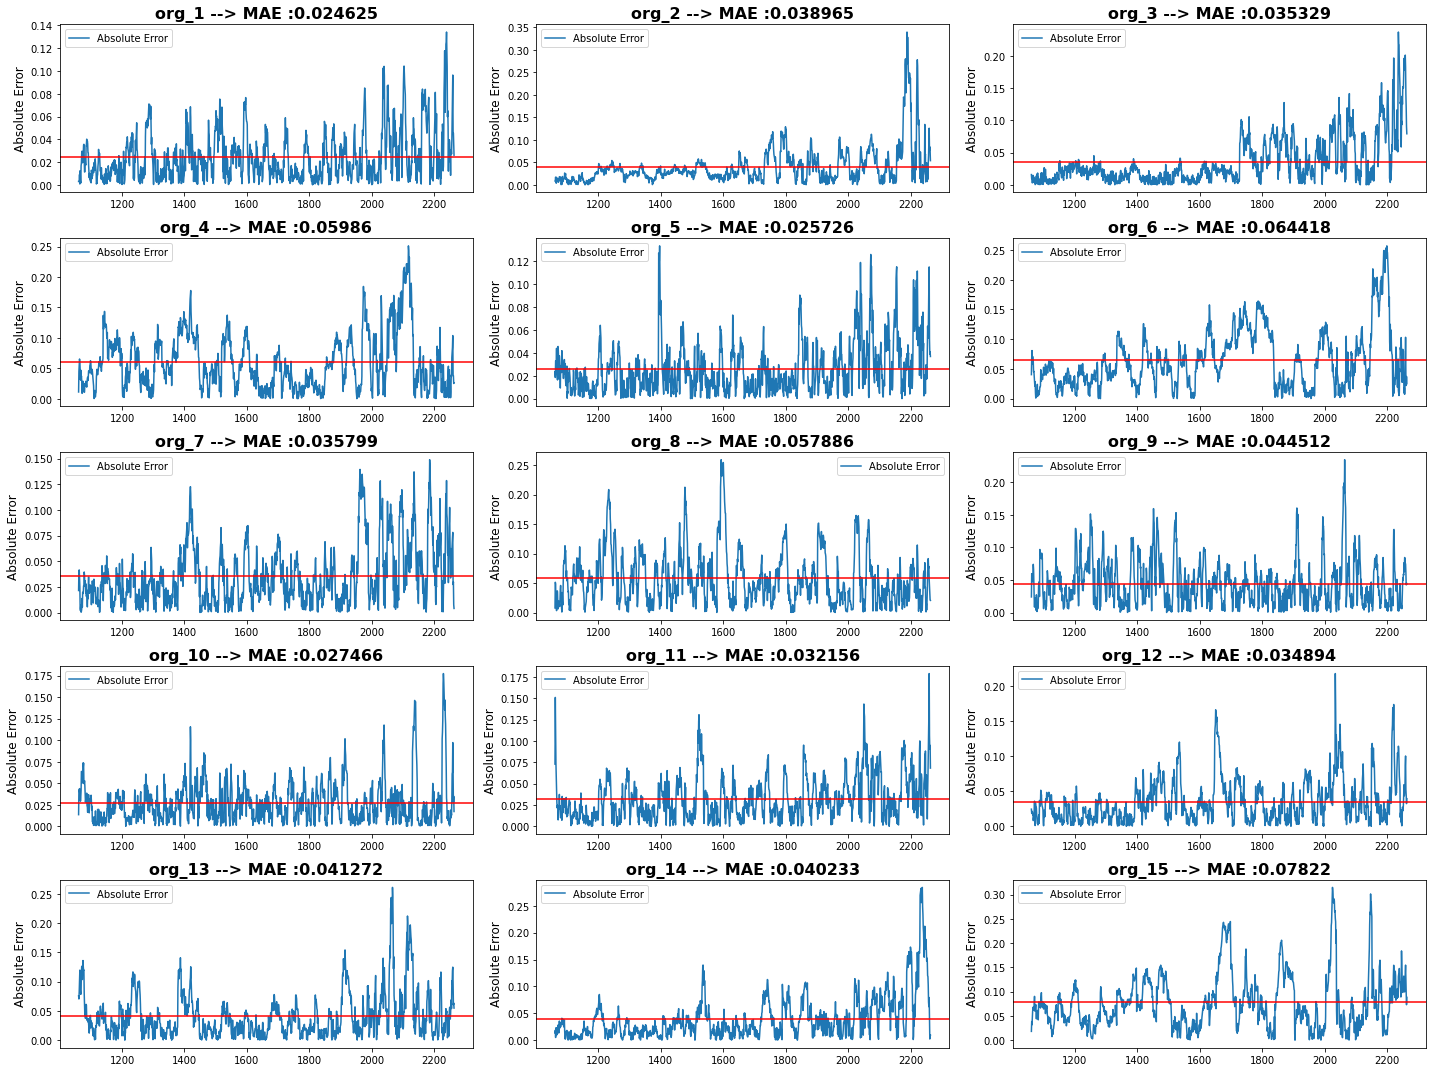

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))

# just prediction
for org_inx in range(1,16):
    df_test = df_test_dict[org_inx].copy()
    day_merge_df = []
    for day in range(1,11):
        # X 준비
        feature = critical_feature_dict[org_inx]['critical_feature'][day]
        df = df_test[feature].copy()
        raw_X = df.values

        # 선형 회귀 모델 호출
        line_fitter = model_dict[org_inx][day]

        # 과거데이터 피팅
        y_old = line_fitter.predict(raw_X)
        
        # 접합
        df['day' + str(day)] = y_old.copy()
        df['day' + str(day)] = df['day' + str(day)].shift(periods = day)
        df = df[['day' + str(day)]].copy()
        
        if len(day_merge_df) > 0:
            day_merge_df = pd.merge(day_merge_df, df, right_index = True, left_index = True, how = 'outer')
        else:
            day_merge_df = df.copy()
            
    df_pred = pd.DataFrame(day_merge_df.mean(axis = 'columns'), columns = ['pred'])
    df_test = df_test[['Close']].copy()
    df_inx = pd.merge(df_pred, df_test, right_index = True, left_index = True)
    df_inx['Absolute Error'] = abs(df_inx['pred'] - df_inx['Close'])
    
    # plot
    plt.subplot(5,3,org_inx)
    df_inx['Absolute Error'].plot(legend = True)
    plt.axhline(y = df_inx['Absolute Error'].mean(),  color='red', linestyle='solid')
    plt.ylabel('Absolute Error', fontsize = 12)
    plt.title("org_" + str(org_inx) + ' --> MAE :' + str(round(df_inx['Absolute Error'].mean(),6)), fontsize = 16, fontweight = 'bold')
        
plt.tight_layout()

전혀 아니었습니다.  
그럼 미래에는 잘 예측할까요? 그건 더 아니겠죠.  

<u>이건 주어진 단 10일, 그 아무 의미 없는 noise에 biasing 되어있는 garbage model일 뿐입니다.</u> 모델링의 핵심인 feature selection과 hyper parameter tuning 과정에서 랭킹보드에 엄청나게 over-fitting된 것이죠.  
이 현상은 랭킹보드의 성적을 더 높게 기록하는 모델일수록 더욱 심화될 가능성이 매우 높습니다.
    
이런 모델들이 정말 운영진이 원하는 우수작 일까요?  

### <strong>운영진 분들께,<strong>

지금이라도 private leaderboard를 만들어 보시는게 어떨지 제안드립니다.  
    
우선 15개의 개별 종목들의 종목명을 공개하고 normalize 된 종목들의 액면가를 복원시켜 주십시오. 그리고 예정된 8/29까지 대회를 운영하고 참여자들에게 <u>8/29 종가를 기준으로 앞으로 10일 간의 종가를 예측한 result를 제출 받으십시오.</u>  
이렇게 제출받은 result와 8/30 - 9/12까지의 해당 종목들의 실제 종가를 운영 측에서 수집해 MAE를 산출, 순위를 정하는 방식 제안드립니다.

지금이라도 이렇게 하지 않으면 개인적으로 이 대회는 "주가 예측" 경진대회라고 부르기 어렵지 않나 싶습니다.

P.S. 이 플랫폼, 사내의 모든 코드와 텍스트/이미지 등을 제한 없이 서버에 업로드 한 후 자택이나 개인 휴대폰에서 다운로드 받을 수 있는 구조로 보입니다.

사내에서 사용하기엔 보안 문제가 심각해보이는데 정식으로 DS 정보 보안 부서에서 컨펌을 받은걸까요?

